## Imports

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from scipy import stats
import matplotlib.ticker as ticker
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter
import math

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout, Conv2D, BatchNormalization, Flatten, Reshape, MaxPooling2D, Bidirectional, ConvLSTM2D
from keras.regularizers import l1, l2

seed = 31102016 
rng = np.random.RandomState(seed)

## Types of recordings of Activities

In [28]:
devices = ["Respeck", "Thingy"]
student_numbers = ['s1','s13', 's21', 's3', 's35', 's42', 's48', 's54', 's60', 's66', 's72', 's8', 's86', 's92', 's98', 's100', 's15', 's22', 's30', 's36', 's43', 's5', 's55', 's61', 's67', 's74', 's80', 's87', 's93', 's102', 's16', 's23', 's32', 's38', 's44', 's50', 's56', 's63', 's7', 's75', 's82', 's88', 's95', 's11', 's17', 's27', 's33', 's39', 's45', 's51', 's57', 's64', 's70', 's77', 's83', 's9', 's96', 's12', 's18', 's29', 's34', 's40', 's46', 's52', 's59', 's65', 's71', 's79', 's84','s91', 's97']
physical_activities = ['ascending', 'descending', 'lyingBack', 'lyingLeft', 'lyingRight', 'lyingStomach', 'miscMovement', 'normalWalking', 'running','shuffleWalking', 'sitting', 'standing']
stationary_activities = ["sitting", "standing", "lyingRight", "lyingLeft", "lyingStomach", "lyingBack"]
respiratory_symptoms = ["breathingNormal", "hyperventilating", "coughing"]
other_behaviours = ["talking", "singing", "eating", "laughing"]

## Build consolidated DF of all recordings

In [3]:
# # Code to consolidate datasets of every students'

# path = 'pdiot-data/updated_anonymized_dataset_2023/Respeck'

# faulty = pd.DataFrame()

# def get_new_dataframe(student_number, activity, sub_activity, file):
#     filename = f"{path}/{student_number}/{file}"
#     df = pd.read_csv(filename, index_col='Unnamed: 0')
#     df['student_number'] = student_number
#     df['activity'] = activity
#     df['sub_activity'] = sub_activity[:-4]
#     return df

# dataset = pd.DataFrame()

# for student_number in student_numbers:
#     for file in os.listdir(path=f"{path}/{student_number}/"):
#         parts = file.split('_')
#         dataset = pd.concat([dataset, get_new_dataframe(student_number, parts[2], parts[3], file)])

# dataset.head(10)

# dataset.to_csv('dataset/consolidated.csv')

/tmp/ipykernel_889235/1660450515.py:43: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = d.mean()
/tmp/ipykernel_889235/1660450515.py:44: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std = d.std()


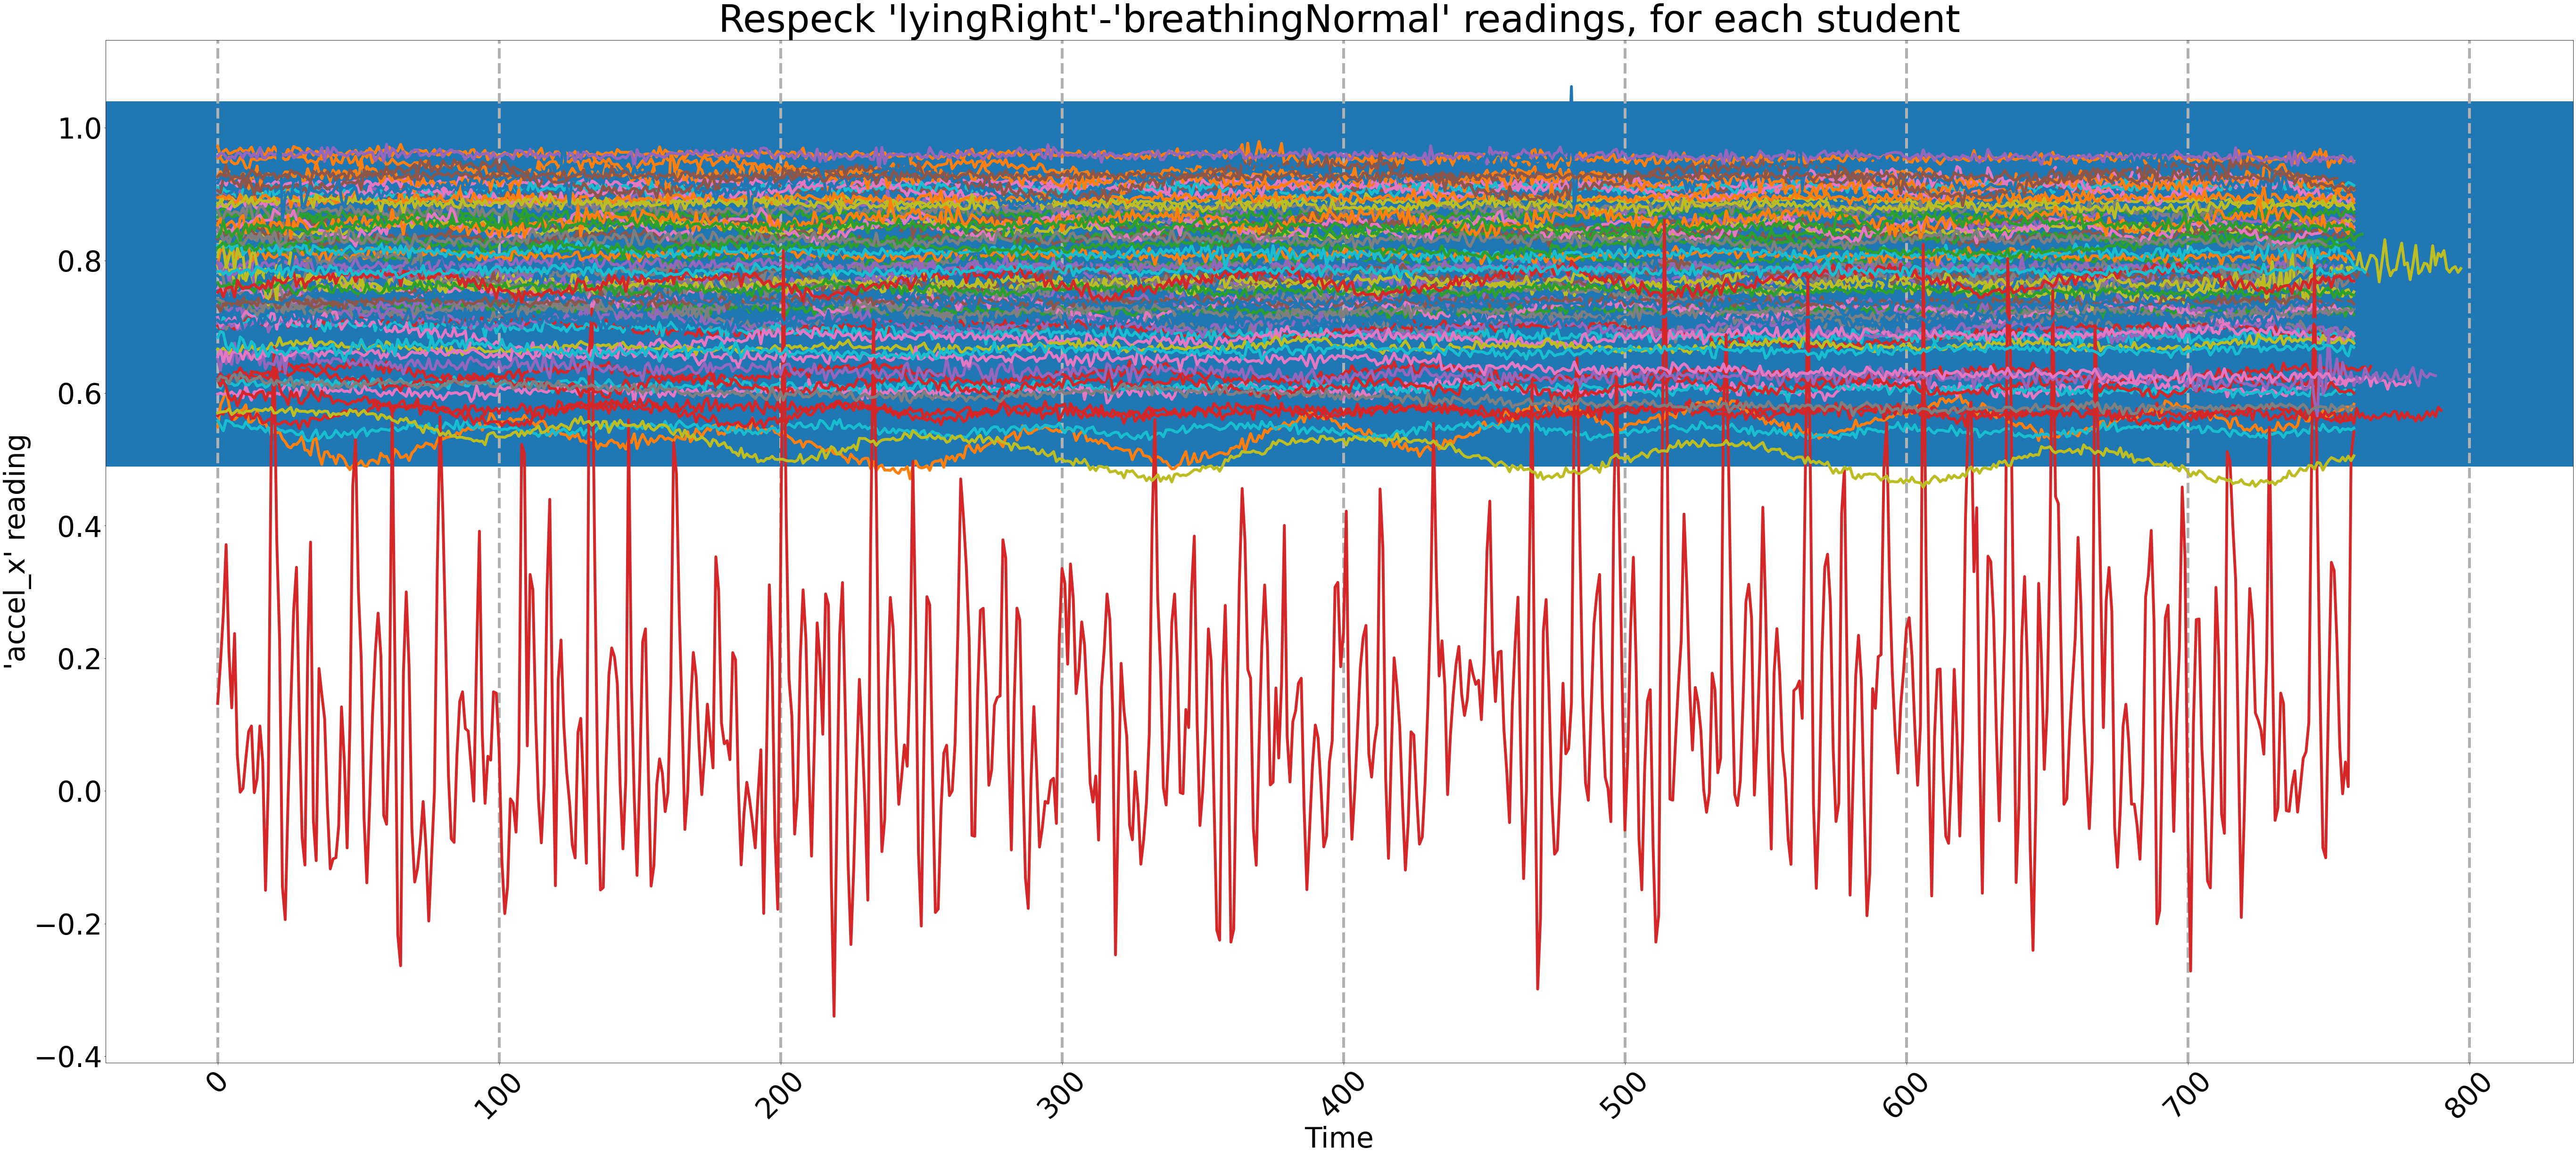

In [45]:
# def plot_data(column, plot_title, mean, std):

#     line_width = 6

#     # Plot respeck with custom line width
#     plt.plot(column, linewidth=line_width)
#     plt.axhspan(ymin=mean-2*std, ymax=mean+2*std, alpha=0.3)
    
#     num_xticks = len(column)//10

#     fnt_size = 60
#     fnt_size2 = 40

#     plt.tick_params(axis='both', labelsize=fnt_size)

#     plt.tick_params(axis='x', labelrotation=45)

#     plt.grid(axis='x', linestyle='--', linewidth=line_width)
    
#     plt.xlabel('Time', fontsize=fnt_size)  
#     plt.ylabel("'accel_x' reading", fontsize=fnt_size)  
#     plt.title("Respeck 'lyingRight'-'breathingNormal' readings, for each student", fontsize=80)

    
# # Calculate the number of data points in your dataset
# num_data_points = 760

# # Calculate a suitable figure width based on the number of data points
# # You can adjust the multiplier as needed to control the figure size
# figure_width = num_data_points / 10  # Adjust the divisor to control the size


# # Set a fixed aspect ratio for the figure (optional)
# aspect_ratio = 0.3  # You can adjust this value as needed

# # Calculate the figure height based on the aspect ratio and width
# figure_height = figure_width * aspect_ratio

# # Create the figure with the calculated size
# fig = plt.figure(figsize=(figure_width, figure_height*1.5))

# d = dataset[(dataset.activity=='lyingRight') & (dataset.sub_activity=='breathingNormal')]
# mean = d.mean()
# std = d.std()

# for s in student_numbers:
#     plot_data(d[d.student_number==s].accel_x, 'title', mean.accel_x, std.accel_x)

# plt.tight_layout()

# plt.savefig('outliers.pdf')
# plt.show()


In [27]:
# # Code to filter out outlier dataframes - includes dfs that fall in the 95 percentile range

# clean = pd.DataFrame()
# activities = dataset.activity.unique()
# sub_activities = dataset.sub_activity.unique()

# i = 0

# for activity in activities:
#     for sub_activity in sub_activities:
#         mean = dataset[(dataset.activity==activity) & (dataset.sub_activity==sub_activity)].mean(numeric_only=True)
#         std = dataset[(dataset.activity==activity) & (dataset.sub_activity==sub_activity)].std(numeric_only=True)

#         for s in student_numbers:
#             d = dataset[(dataset.student_number==s) & (dataset.activity==activity) & (dataset.sub_activity==sub_activity)]
#             m = d[['accel_x', 'accel_y', 'accel_z']].mean()
            
#             if m.accel_x <= mean.accel_x+2*std.accel_x and m.accel_x >= mean.accel_x-2*std.accel_x and m.accel_y <= mean.accel_y+2*std.accel_y and m.accel_y >= mean.accel_y-2*std.accel_y and m.accel_z <= mean.accel_z+2*std.accel_z and m.accel_z >= mean.accel_z-2*std.accel_z:
#                 clean = pd.concat([clean, d]) 
                
#         print(i,'/84')
#         i+=1
    
# clean.to_csv("dataset/consolidated_filtered.csv")
# clean


0 /84
1 /84
2 /84
3 /84
4 /84
5 /84
6 /84
7 /84
8 /84
9 /84
10 /84
11 /84
12 /84
13 /84
14 /84
15 /84
16 /84
17 /84
18 /84
19 /84
20 /84
21 /84
22 /84
23 /84
24 /84
25 /84
26 /84
27 /84
28 /84
29 /84
30 /84
31 /84
32 /84
33 /84
34 /84
35 /84
36 /84
37 /84
38 /84
39 /84
40 /84
41 /84
42 /84
43 /84
44 /84
45 /84
46 /84
47 /84
48 /84
49 /84
50 /84
51 /84
52 /84
53 /84
54 /84
55 /84
56 /84
57 /84
58 /84
59 /84
60 /84
61 /84
62 /84
63 /84
64 /84
65 /84
66 /84
67 /84
68 /84
69 /84
70 /84
71 /84
72 /84
73 /84
74 /84
75 /84
76 /84
77 /84
78 /84
79 /84
80 /84
81 /84
82 /84
83 /84


timestamp   accel_x   accel_y   accel_z    gyro_x    gyro_y    gyro_z  \
0    1697605965  0.011963 -0.855774 -0.029846 -9.625000 -0.859375 -5.656250   
1    1697606005 -0.001709 -0.826233 -0.036194  0.359375  4.953125 -1.656250   
2    1697606045 -0.058838 -0.933899 -0.032532  3.437500  9.406250 -2.031250   
3    1697606085 -0.002441 -1.115051 -0.028870  3.078125  6.921875 -5.984375   
4    1697606125 -0.036621 -1.035217 -0.076477  4.328125  8.125000  0.625000   
..          ...       ...       ...       ...       ...       ...       ...   
759  1697636325 -0.217041 -0.994934  0.113220 -2.718750 -1.390625 -1.656250   
760  1697636365 -0.203369 -0.979309  0.107849 -2.500000  0.843750 -0.968750   
761  1697636405 -0.186279 -0.982727  0.116638 -1.984375 -0.359375 -0.781250   
762  1697636445 -0.206055 -0.972229  0.129333 -1.343750  0.031250 -0.406250   
763  1697636485 -0.199951 -0.978088  0.128113 -1.265625  0.812500 -0.421875   

    student_number   activity     sub_activity  
0               s1  ascending  breathingNormal  
1               s1  ascending  breathingNormal  
2               s1  ascending  breathingNormal  
3               s1  ascending  breathingNormal  
4               s1  ascending  breathingNormal  
..             ...        ...              ...  
759            s97   standing           eating  
760            s97   standing           eating  
761            s97   standing           eating  
762            s97   standing           eating  
763            s97   standing           eating  

[2168886 rows x 10 columns]

In [5]:
# filename = "dataset/consolidated_filtered.csv" # filtered data
filename = "dataset/consolidated.csv"  # raw consolidated data
dataset = pd.read_csv(filename, index_col='Unnamed: 0')

dataset.head(10)

timestamp   accel_x   accel_y   accel_z     gyro_x     gyro_y    gyro_z  \
0  1697605965  0.011963 -0.855774 -0.029846  -9.625000  -0.859375 -5.656250   
1  1697606005 -0.001709 -0.826233 -0.036194   0.359375   4.953125 -1.656250   
2  1697606045 -0.058838 -0.933899 -0.032532   3.437500   9.406250 -2.031250   
3  1697606085 -0.002441 -1.115051 -0.028870   3.078125   6.921875 -5.984375   
4  1697606125 -0.036621 -1.035217 -0.076477   4.328125   8.125000  0.625000   
5  1697606165  0.099609 -1.242249 -0.221252  16.453125  -6.171875 -1.015625   
6  1697606205  0.238770 -1.436584 -0.275452  13.312500  -8.796875  6.906250   
7  1697606245  0.625000 -1.344299 -0.260315   8.843750 -16.750000  8.406250   
8  1697606285 -0.001465 -0.848938 -0.085266  -9.062500  -7.078125  5.781250   
9  1697606325  0.411377 -0.892395 -0.272278   7.312500 -19.015625  5.421875   

  student_number   activity     sub_activity  is_stationary  activity_label  \
0             s1  ascending  breathingNormal              0               0   
1             s1  ascending  breathingNormal              0               0   
2             s1  ascending  breathingNormal              0               0   
3             s1  ascending  breathingNormal              0               0   
4             s1  ascending  breathingNormal              0               0   
5             s1  ascending  breathingNormal              0               0   
6             s1  ascending  breathingNormal              0               0   
7             s1  ascending  breathingNormal              0               0   
8             s1  ascending  breathingNormal              0               0   
9             s1  ascending  breathingNormal              0               0   

   sub_activity_label  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
5                   0  
6                   0  
7                   0  
8                   0  
9                   0

In [41]:
# d = {}
# for k in stationary_activities:
#     d[k] = 1
# x = ['ascending', 'descending', 'miscMovement', 'normalWalking', 'running','shuffleWalking']
# for k in x:
#     d[k] = 0
# dataset['is_stationary'] = dataset['activity'].replace(d)
# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(dataset.activity)

# dataset['label'] = encoded_labels
# dataset['activity_label'] = dataset['label']
# dataset = dataset.drop('label', axis=1)

# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(dataset.sub_activity)

# dataset['sub_activity_label'] = encoded_labels
# dataset.head(10)
# dataset.to_csv('dataset/consolidated.csv')

# Activity Recognition

## Sliding window to generate overlapping intervals of recordings
Interval size is temporarily set to 2 secs (ie, 50 recording points)

In [21]:
SENSOR_CHANNELS = 3
SLIDING_WINDOW_LENGTH = 125

step = 10
segments = []
labels = []

for i in range(0, len(dataset)-SLIDING_WINDOW_LENGTH, step):
    xs = dataset['accel_x'].values[i: i+SLIDING_WINDOW_LENGTH]
    ys = dataset['accel_y'].values[i: i+SLIDING_WINDOW_LENGTH]
    zs = dataset['accel_z'].values[i: i+SLIDING_WINDOW_LENGTH]
    
    label = stats.mode(dataset['activity_label'][i: i+SLIDING_WINDOW_LENGTH])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

Transform shape

In [22]:
# reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, SLIDING_WINDOW_LENGTH, SENSOR_CHANNELS)

reshaped_segments = np.asarray(segments)
reshaped_segments.shape

(216877, 3, 125)

One hot encoding of labels 

In [23]:
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)
# labels = np.asarray(labels)
labels.shape

(216877, 12)

Finally, let's split the data into training and test (20%) set:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    reshaped_segments, labels, test_size=0.2, random_state=rng)

print(" ..after sliding and reshaping, train data: inputs {0}, targets {1}".format(X_train.shape, y_train.shape))
print(" ..after sliding and reshaping, test data : inputs {0}, targets {1}".format(X_test.shape, y_test.shape))

 ..after sliding and reshaping, train data: inputs (173501, 3, 125), targets (173501, 12)
 ..after sliding and reshaping, test data : inputs (43376, 3, 125), targets (43376, 12)


## Bidirectional LSTM - 128
Modify hyperparameters

In [9]:
batch_size = 32
output_dim = 12
epochs = 100
dropout_rate = 0.1

input_shape=(SENSOR_CHANNELS, SLIDING_WINDOW_LENGTH)

# Conv2D parameters
n_filters = 64
kernel_size = (3,3)
n_neurons = 64

# LSTM parameters
n_neurons_lstm = 128

# optimization parameters
lr = 0.0015
decay = 1e-6

In [10]:
model = Sequential()

model.add(Bidirectional(LSTM(units = n_neurons_lstm, activation='relu',
                             kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)), input_shape = (3, 50)))
model.add(Dropout(dropout_rate))

model.add(Dense(n_neurons, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(dropout_rate))
model.add(Dense(output_dim, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

adam = Adam(learning_rate=lr, weight_decay=decay)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256)               183296    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                780       
                                                                 
Total params: 200524 (783.30 KB)
Trainable params: 200524 (783.30 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [11]:
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.20, batch_size = batch_size, verbose = 1)
model.evaluate(X_test, y_test, batch_size = 32, verbose = 1)

Epoch 1/100
4338/4338 [==============================] - 26s 5ms/step - loss: 0.4197 - accuracy: 0.8104 - val_loss: 0.3462 - val_accuracy: 0.8273
Epoch 2/100
4338/4338 [==============================] - 19s 4ms/step - loss: 0.3213 - accuracy: 0.8478 - val_loss: 0.2921 - val_accuracy: 0.8644
Epoch 3/100
4338/4338 [==============================] - 18s 4ms/step - loss: 0.2863 - accuracy: 0.8607 - val_loss: 0.2742 - val_accuracy: 0.8680
Epoch 4/100
4338/4338 [==============================] - 26s 6ms/step - loss: 0.2699 - accuracy: 0.8671 - val_loss: 0.2664 - val_accuracy: 0.8685
Epoch 5/100
4338/4338 [==============================] - 25s 6ms/step - loss: 0.2595 - accuracy: 0.8712 - val_loss: 0.2611 - val_accuracy: 0.8738
Epoch 6/100
4338/4338 [==============================] - 20s 5ms/step - loss: 0.2504 - accuracy: 0.8744 - val_loss: 0.2501 - val_accuracy: 0.8782
Epoch 7/100
4338/4338 [==============================] - 18s 4ms/step - loss: 0.2445 - accuracy: 0.8772 - val_loss: 0.2543 -

Epoch 57/100
4338/4338 [==============================] - 18s 4ms/step - loss: 0.1820 - accuracy: 0.9170 - val_loss: 0.3166 - val_accuracy: 0.9024
Epoch 58/100
4338/4338 [==============================] - 20s 5ms/step - loss: 0.1826 - accuracy: 0.9169 - val_loss: 0.3132 - val_accuracy: 0.8997
Epoch 59/100
4338/4338 [==============================] - 26s 6ms/step - loss: 0.1832 - accuracy: 0.9177 - val_loss: 0.3043 - val_accuracy: 0.9016
Epoch 60/100
4338/4338 [==============================] - 25s 6ms/step - loss: 0.1800 - accuracy: 0.9185 - val_loss: 0.3529 - val_accuracy: 0.9021
Epoch 61/100
4338/4338 [==============================] - 19s 4ms/step - loss: 0.1834 - accuracy: 0.9174 - val_loss: 0.3318 - val_accuracy: 0.8980
Epoch 62/100
4338/4338 [==============================] - 18s 4ms/step - loss: 0.1831 - accuracy: 0.9181 - val_loss: 0.3117 - val_accuracy: 0.9041
Epoch 63/100
4338/4338 [==============================] - 24s 5ms/step - loss: 0.1818 - accuracy: 0.9183 - val_loss: 0

[0.41868552565574646, 0.9064019918441772]

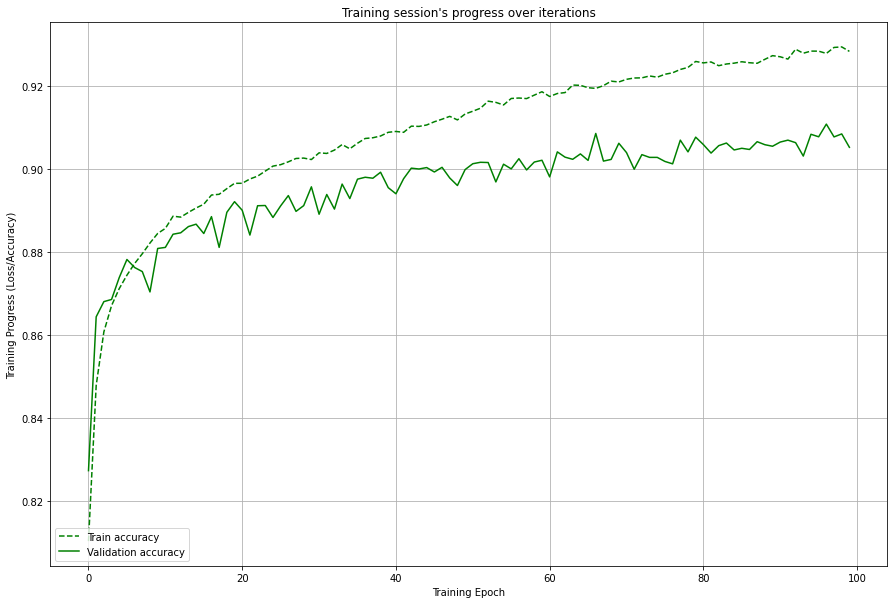

In [12]:
plt.figure(figsize=(15,10))
# plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
# plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
# plt.ylim(0)
plt.grid()
plt.show()

## Bidirectional LSTM - 256

In [8]:
batch_size = 32
output_dim = 12
epochs = 100
dropout_rate = 0.1

input_shape=(SENSOR_CHANNELS, SLIDING_WINDOW_LENGTH)

# LSTM parameters
n_neurons_lstm = 256

n_neurons = 64

# optimization parameters
lr = 0.0015
decay = 1e-6

model = Sequential()

model.add(Bidirectional(LSTM(units = n_neurons_lstm, activation='relu',
                             kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)), input_shape = input_shape))
model.add(Dropout(dropout_rate))

model.add(Dense(n_neurons, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(dropout_rate))
model.add(Dense(output_dim, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

adam = Adam(learning_rate=lr, weight_decay=decay)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 512)               628736    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                780       
                                                                 
Total params: 662348 (2.53 MB)
Trainable params: 662348 (2.53 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [9]:
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.20, batch_size = batch_size, verbose = 1)
model.evaluate(X_test, y_test, batch_size = 32, verbose = 1)

Epoch 1/100
4338/4338 [==============================] - 31s 7ms/step - loss: 0.4134 - accuracy: 0.8137 - val_loss: 0.3244 - val_accuracy: 0.8474
Epoch 2/100
4338/4338 [==============================] - 28s 7ms/step - loss: 0.3102 - accuracy: 0.8533 - val_loss: 0.2905 - val_accuracy: 0.8608
Epoch 3/100
4338/4338 [==============================] - 28s 7ms/step - loss: 0.2811 - accuracy: 0.8632 - val_loss: 0.2740 - val_accuracy: 0.8682
Epoch 4/100
4338/4338 [==============================] - 28s 7ms/step - loss: 0.2656 - accuracy: 0.8685 - val_loss: 0.2713 - val_accuracy: 0.8682
Epoch 5/100
4338/4338 [==============================] - 29s 7ms/step - loss: 0.2559 - accuracy: 0.8734 - val_loss: 0.2641 - val_accuracy: 0.8722
Epoch 6/100
4338/4338 [==============================] - 29s 7ms/step - loss: 0.2470 - accuracy: 0.8762 - val_loss: 0.2650 - val_accuracy: 0.8769
Epoch 7/100
4338/4338 [==============================] - 28s 7ms/step - loss: 0.2399 - accuracy: 0.8794 - val_loss: 0.2663 -

Epoch 57/100
4338/4338 [==============================] - 29s 7ms/step - loss: 0.1780 - accuracy: 0.9245 - val_loss: 0.4110 - val_accuracy: 0.9065
Epoch 58/100
4338/4338 [==============================] - 29s 7ms/step - loss: 0.1783 - accuracy: 0.9253 - val_loss: 0.3443 - val_accuracy: 0.9082
Epoch 59/100
4338/4338 [==============================] - 29s 7ms/step - loss: 0.1784 - accuracy: 0.9247 - val_loss: 0.3718 - val_accuracy: 0.9044
Epoch 60/100
4338/4338 [==============================] - 29s 7ms/step - loss: 0.1764 - accuracy: 0.9252 - val_loss: 0.3805 - val_accuracy: 0.9072
Epoch 61/100
4338/4338 [==============================] - 29s 7ms/step - loss: 0.1764 - accuracy: 0.9261 - val_loss: 0.4158 - val_accuracy: 0.9067
Epoch 62/100
4338/4338 [==============================] - 29s 7ms/step - loss: 0.1748 - accuracy: 0.9258 - val_loss: 0.4041 - val_accuracy: 0.9046
Epoch 63/100
4338/4338 [==============================] - 29s 7ms/step - loss: 0.1744 - accuracy: 0.9269 - val_loss: 0

[0.5878658890724182, 0.9117043614387512]

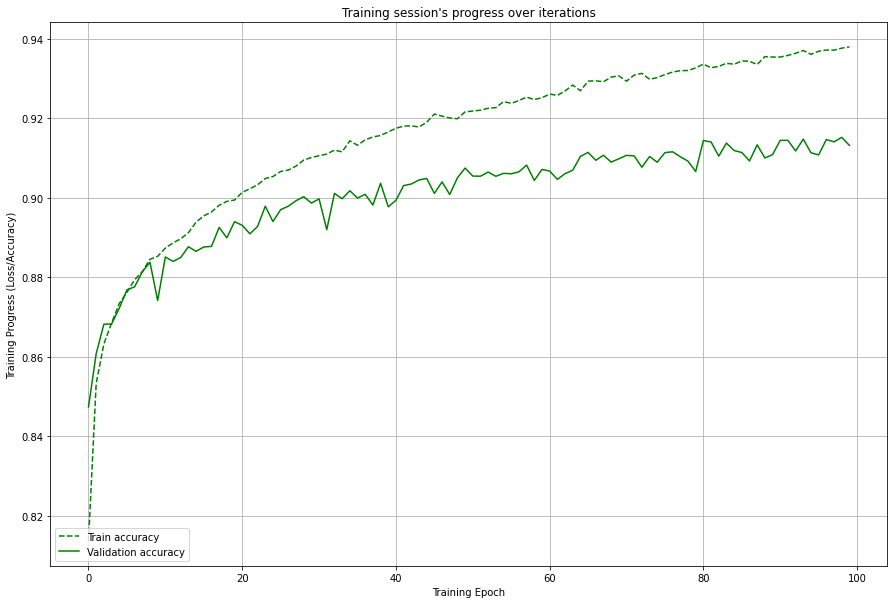

In [10]:
plt.figure(figsize=(15,10))
# plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
# plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
# plt.ylim(0)
plt.grid()
plt.show()

## Bidirectional LSTM - 256, batch size 128

In [11]:
batch_size = 128
output_dim = 12
epochs = 100
dropout_rate = 0.1

input_shape=(SENSOR_CHANNELS, SLIDING_WINDOW_LENGTH)

# LSTM parameters
n_neurons_lstm = 256

# optimization parameters
lr = 0.002
decay = 1e-6

model = Sequential()

model.add(Bidirectional(LSTM(units = n_neurons_lstm, activation='relu',
                             kernel_regularizer=l2(0.000002), bias_regularizer=l2(0.000002)), input_shape=(3,50)))
model.add(Dropout(dropout_rate))

model.add(Dense(n_neurons, activation='relu', kernel_regularizer=l2(0.000002), bias_regularizer=l2(0.000002)))

model.add(Dense(output_dim, activation='softmax', kernel_regularizer=l2(0.000002), bias_regularizer=l2(0.000002)))

adam = Adam(learning_rate=lr, weight_decay=decay)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 512)               628736    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 12)                780       
                                                                 
Total params: 662348 (2.53 MB)
Trainable params: 662348 (2.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.20, batch_size = 128, verbose = 1)
model.evaluate(X_test, y_test, batch_size = 128, verbose = 1)

Epoch 1/100
1085/1085 [==============================] - 14s 11ms/step - loss: 0.4410 - accuracy: 0.8040 - val_loss: 0.3707 - val_accuracy: 0.8287
Epoch 2/100
1085/1085 [==============================] - 12s 11ms/step - loss: 0.3237 - accuracy: 0.8457 - val_loss: 0.2898 - val_accuracy: 0.8638
Epoch 3/100
1085/1085 [==============================] - 12s 11ms/step - loss: 0.2844 - accuracy: 0.8610 - val_loss: 0.2738 - val_accuracy: 0.8676
Epoch 4/100
1085/1085 [==============================] - 12s 11ms/step - loss: 0.2665 - accuracy: 0.8679 - val_loss: 0.2735 - val_accuracy: 0.8691
Epoch 5/100
1085/1085 [==============================] - 12s 11ms/step - loss: 0.2532 - accuracy: 0.8723 - val_loss: 0.2693 - val_accuracy: 0.8687
Epoch 6/100
1085/1085 [==============================] - 12s 11ms/step - loss: 0.2445 - accuracy: 0.8764 - val_loss: 0.2604 - val_accuracy: 0.8767
Epoch 7/100
1085/1085 [==============================] - 12s 11ms/step - loss: 0.2360 - accuracy: 0.8807 - val_loss: 0

[0.31296512484550476, 0.9230237007141113]

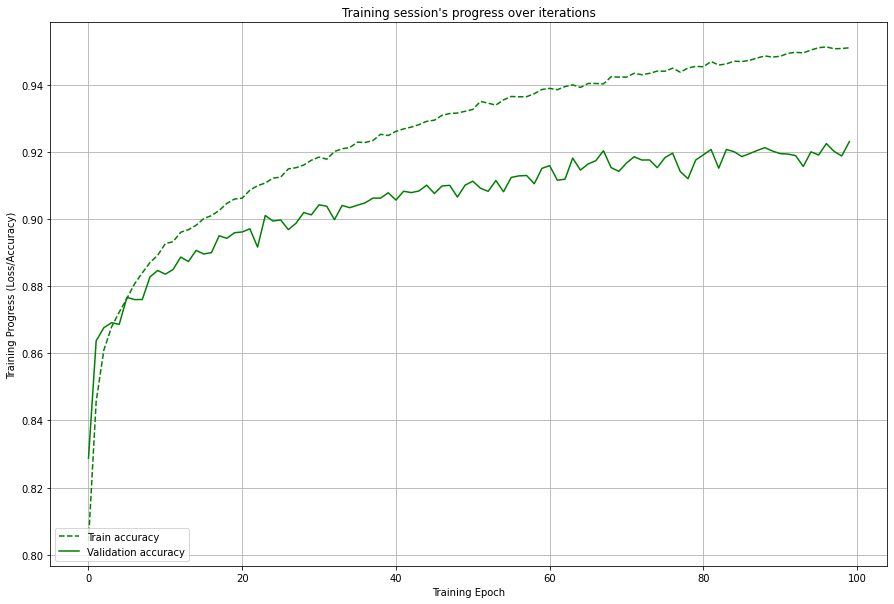

In [13]:
plt.figure(figsize=(15,10))
# plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
# plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
# plt.ylim(0)
plt.grid()
plt.show()

## CNN - 1 layer

In [8]:
batch_size = 32
output_dim = 12
epochs = 100
dropout_rate = 0.1

input_shape=(SENSOR_CHANNELS, SLIDING_WINDOW_LENGTH)

# Conv2D parameters
n_filters = 64
kernel_size = (3,3)
n_neurons = 64

# optimization parameters
lr = 0.0015
decay = 1e-6

model = Sequential()

model.add(Reshape((3, 50, 1), input_shape=(3,50)))

model.add(Conv2D(16, kernel_size=kernel_size, activation='relu', padding='same', input_shape=model.output_shape,
                 kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Flatten())

model.add(Dense(n_neurons, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(dropout_rate))
model.add(Dense(output_dim, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

adam = Adam(learning_rate=lr, weight_decay=decay)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3, 50, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 3, 50, 16)         160       
                                                                 
 batch_normalization (Batch  (None, 3, 50, 16)         64        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 3, 50, 16)         0         
                                                                 
 flatten (Flatten)           (None, 2400)              0         
                                                                 
 dense (Dense)               (None, 64)                153664    
                                                        

In [9]:
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.20, batch_size = batch_size, verbose = 1)
model.evaluate(X_test, y_test, batch_size = 32, verbose = 1)

Epoch 1/100
4338/4338 [==============================] - 16s 3ms/step - loss: 0.4512 - accuracy: 0.8001 - val_loss: 0.3673 - val_accuracy: 0.8315
Epoch 2/100
4338/4338 [==============================] - 15s 3ms/step - loss: 0.3630 - accuracy: 0.8323 - val_loss: 0.3440 - val_accuracy: 0.8454
Epoch 3/100
4338/4338 [==============================] - 15s 3ms/step - loss: 0.3355 - accuracy: 0.8432 - val_loss: 0.3096 - val_accuracy: 0.8538
Epoch 4/100
4338/4338 [==============================] - 15s 3ms/step - loss: 0.3207 - accuracy: 0.8490 - val_loss: 0.3043 - val_accuracy: 0.8590
Epoch 5/100
4338/4338 [==============================] - 15s 3ms/step - loss: 0.3090 - accuracy: 0.8537 - val_loss: 0.2938 - val_accuracy: 0.8633
Epoch 6/100
4338/4338 [==============================] - 15s 3ms/step - loss: 0.2991 - accuracy: 0.8575 - val_loss: 0.2970 - val_accuracy: 0.8620
Epoch 7/100
4338/4338 [==============================] - 14s 3ms/step - loss: 0.2914 - accuracy: 0.8603 - val_loss: 0.2904 -

Epoch 57/100
4338/4338 [==============================] - 15s 3ms/step - loss: 0.2456 - accuracy: 0.8851 - val_loss: 0.3063 - val_accuracy: 0.8758
Epoch 58/100
4338/4338 [==============================] - 15s 3ms/step - loss: 0.2480 - accuracy: 0.8841 - val_loss: 0.2976 - val_accuracy: 0.8745
Epoch 59/100
4338/4338 [==============================] - 15s 3ms/step - loss: 0.2462 - accuracy: 0.8836 - val_loss: 0.3004 - val_accuracy: 0.8726
Epoch 60/100
4338/4338 [==============================] - 15s 3ms/step - loss: 0.2468 - accuracy: 0.8838 - val_loss: 0.2946 - val_accuracy: 0.8793
Epoch 61/100
4338/4338 [==============================] - 15s 3ms/step - loss: 0.2463 - accuracy: 0.8845 - val_loss: 0.3052 - val_accuracy: 0.8723
Epoch 62/100
4338/4338 [==============================] - 15s 3ms/step - loss: 0.2470 - accuracy: 0.8841 - val_loss: 0.2902 - val_accuracy: 0.8779
Epoch 63/100
4338/4338 [==============================] - 15s 3ms/step - loss: 0.2457 - accuracy: 0.8850 - val_loss: 0

[0.31412264704704285, 0.8764322400093079]

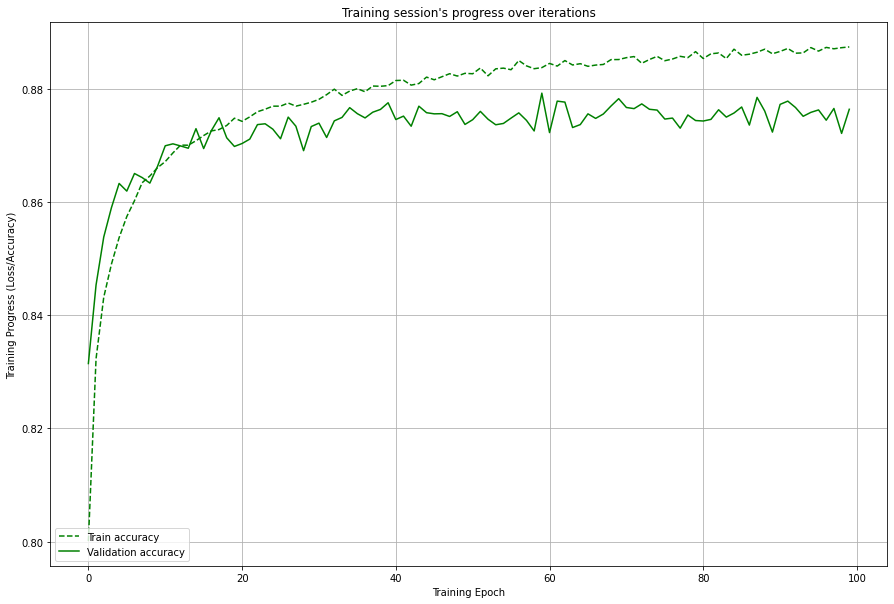

In [10]:
plt.figure(figsize=(15,10))
# plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
# plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
# plt.ylim(0)
plt.grid()
plt.show()

## CNN - 2 layers

In [8]:
batch_size = 32
output_dim = 12
epochs = 100
dropout_rate = 0.1

input_shape=(SENSOR_CHANNELS, SLIDING_WINDOW_LENGTH)

# Conv2D parameters
n_filters = 64
kernel_size = (3,3)
n_neurons = 64

# optimization parameters
lr = 0.0015
decay = 1e-6

model = Sequential()

model.add(Reshape((3, 50, 1), input_shape=(3,50)))

model.add(Conv2D(16, kernel_size=kernel_size, activation='relu', padding='same', input_shape=model.output_shape,
                 kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, kernel_size=kernel_size, activation='relu', padding='same',
                 kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Flatten())

model.add(Dense(n_neurons, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(dropout_rate))
model.add(Dense(output_dim, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

adam = Adam(learning_rate=lr, weight_decay=decay)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3, 50, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 3, 50, 16)         160       
                                                                 
 batch_normalization (Batch  (None, 3, 50, 16)         64        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 3, 50, 16)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 50, 64)         9280      
                                                                 
 batch_normalization_1 (Bat  (None, 3, 50, 64)         256       
 chNormalization)                                       

In [9]:
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.20, batch_size = batch_size, verbose = 1)
model.evaluate(X_test, y_test, batch_size = 32, verbose = 1)

Epoch 1/100
4338/4338 [==============================] - 46s 10ms/step - loss: 0.5353 - accuracy: 0.7619 - val_loss: 0.4606 - val_accuracy: 0.7979
Epoch 2/100
4338/4338 [==============================] - 44s 10ms/step - loss: 0.4207 - accuracy: 0.8006 - val_loss: 0.3597 - val_accuracy: 0.8313
Epoch 3/100
4338/4338 [==============================] - 44s 10ms/step - loss: 0.3687 - accuracy: 0.8265 - val_loss: 0.3248 - val_accuracy: 0.8491
Epoch 4/100
4338/4338 [==============================] - 44s 10ms/step - loss: 0.3328 - accuracy: 0.8437 - val_loss: 0.3216 - val_accuracy: 0.8567
Epoch 5/100
4338/4338 [==============================] - 44s 10ms/step - loss: 0.3108 - accuracy: 0.8543 - val_loss: 0.4133 - val_accuracy: 0.8106
Epoch 6/100
4338/4338 [==============================] - 44s 10ms/step - loss: 0.2970 - accuracy: 0.8586 - val_loss: 0.2739 - val_accuracy: 0.8706
Epoch 7/100
4338/4338 [==============================] - 44s 10ms/step - loss: 0.2833 - accuracy: 0.8639 - val_loss: 0

[0.29126572608947754, 0.8866680264472961]

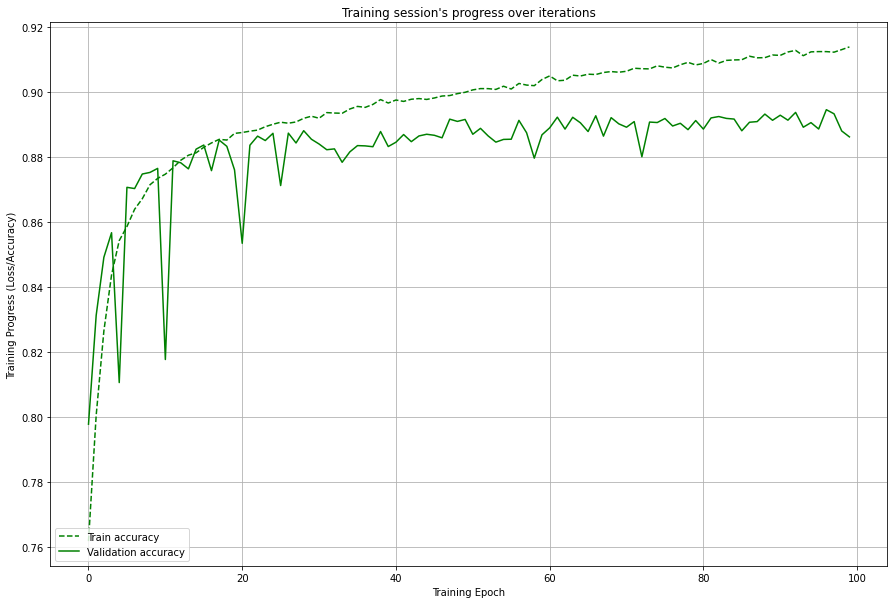

In [10]:
plt.figure(figsize=(15,10))
# plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
# plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
# plt.ylim(0)
plt.grid()
plt.show()

# Bidirectional LSTM - 256, 128 batch size (with class weighting)

In [25]:
batch_size = 128
output_dim = 12
epochs = 100
dropout_rate = 0.1

input_shape=(SENSOR_CHANNELS, SLIDING_WINDOW_LENGTH)

# LSTM parameters
n_neurons_lstm = 256
n_neurons = 64

# optimization parameters
lr = 0.0015
decay = 1e-6

model = Sequential()

model.add(Bidirectional(LSTM(units = n_neurons_lstm, activation='relu',
                             kernel_regularizer=l2(0.000002), bias_regularizer=l2(0.000002)), input_shape=(3,125)))
model.add(Dropout(dropout_rate))

model.add(Dense(n_neurons, activation='relu', kernel_regularizer=l2(0.000002), bias_regularizer=l2(0.000002)))

model.add(Dense(output_dim, activation='softmax', kernel_regularizer=l2(0.000002), bias_regularizer=l2(0.000002)))

adam = Adam(learning_rate=lr, weight_decay=decay)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 512)               782336    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 12)                780       
                                                                 
Total params: 815948 (3.11 MB)
Trainable params: 815948 (3.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.20, batch_size = batch_size, verbose = 1)
model.evaluate(X_test, y_test, batch_size = 32, verbose = 1)

Epoch 1/100
1085/1085 [==============================] - 27s 22ms/step - loss: 0.4535 - accuracy: 0.8019 - val_loss: 0.3628 - val_accuracy: 0.8332
Epoch 2/100
1085/1085 [==============================] - 24s 22ms/step - loss: 0.3358 - accuracy: 0.8418 - val_loss: 0.3249 - val_accuracy: 0.8521
Epoch 3/100
1085/1085 [==============================] - 24s 22ms/step - loss: 0.2950 - accuracy: 0.8580 - val_loss: 0.2805 - val_accuracy: 0.8689
Epoch 4/100
1085/1085 [==============================] - 24s 22ms/step - loss: 0.2636 - accuracy: 0.8708 - val_loss: 0.2753 - val_accuracy: 0.8614
Epoch 5/100
1085/1085 [==============================] - 24s 22ms/step - loss: 0.2450 - accuracy: 0.8777 - val_loss: 0.2718 - val_accuracy: 0.8722
Epoch 6/100
1085/1085 [==============================] - 24s 22ms/step - loss: 0.2328 - accuracy: 0.8824 - val_loss: 0.2484 - val_accuracy: 0.8810
Epoch 7/100
1085/1085 [==============================] - 24s 23ms/step - loss: 0.2220 - accuracy: 0.8873 - val_loss: 0

KeyboardInterrupt: 

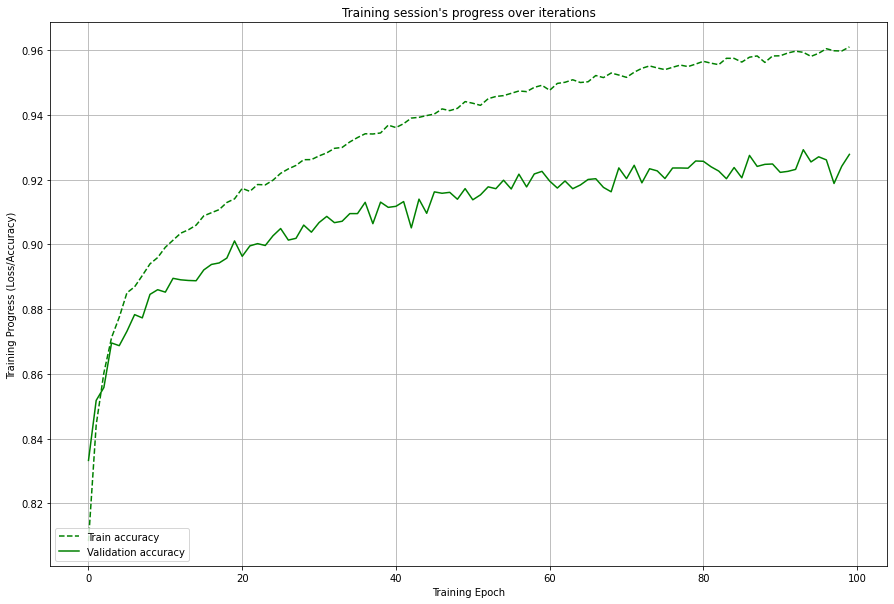

In [33]:
plt.figure(figsize=(15,10))
# plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
# plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
# plt.ylim(0)
plt.grid()
plt.show()

# Sub-activity Recognition

Filter dataset

In [4]:
stationary_dataset = dataset[dataset.is_stationary == 1]
stationary_dataset.head(10)

timestamp   accel_x   accel_y   accel_z    gyro_x    gyro_y    gyro_z  \
0  1697605965 -0.596436 -0.181213  0.870056  0.468750 -0.296875  0.015625   
1  1697606005 -0.593994 -0.189026  0.880310  0.937500 -0.390625 -0.125000   
2  1697606045 -0.591064 -0.172668  0.883484  1.125000 -0.500000 -0.140625   
3  1697606085 -0.580322 -0.176819  0.875671 -0.234375 -0.781250  0.031250   
4  1697606125 -0.598145 -0.189758  0.882263  0.421875 -1.031250 -0.031250   
5  1697606165 -0.586914 -0.175110  0.877625  0.296875 -0.515625  0.078125   
6  1697606205 -0.597168 -0.181458  0.870300  0.203125 -0.203125  0.187500   
7  1697606245 -0.589111 -0.175354  0.880310  0.890625 -0.500000  0.031250   
8  1697606285 -0.601318 -0.187317  0.881042  1.093750  0.562500  0.281250   
9  1697606325 -0.593018 -0.182434  0.876404  0.703125  0.296875  0.062500   

  student_number   activity     sub_activity  is_stationary  activity_label  \
0             s1  lyingBack  breathingNormal              1               2   
1             s1  lyingBack  breathingNormal              1               2   
2             s1  lyingBack  breathingNormal              1               2   
3             s1  lyingBack  breathingNormal              1               2   
4             s1  lyingBack  breathingNormal              1               2   
5             s1  lyingBack  breathingNormal              1               2   
6             s1  lyingBack  breathingNormal              1               2   
7             s1  lyingBack  breathingNormal              1               2   
8             s1  lyingBack  breathingNormal              1               2   
9             s1  lyingBack  breathingNormal              1               2   

   sub_activity_label  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
5                   0  
6                   0  
7                   0  
8                   0  
9                   0

Sliding Window

In [5]:
SENSOR_CHANNELS = 3
SLIDING_WINDOW_LENGTH = 50

step = 10
segments = []
labels = []

for i in range(0, len(stationary_dataset)-SLIDING_WINDOW_LENGTH, step):
    xs = stationary_dataset['accel_x'].values[i: i+SLIDING_WINDOW_LENGTH]
    ys = stationary_dataset['accel_y'].values[i: i+SLIDING_WINDOW_LENGTH]
    zs = stationary_dataset['accel_z'].values[i: i+SLIDING_WINDOW_LENGTH]
    
    label = stats.mode(stationary_dataset['sub_activity'][i: i+SLIDING_WINDOW_LENGTH])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [6]:
reshaped_segments = np.asarray(segments)
reshaped_segments.shape

(186054, 3, 50)

In [7]:
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)
# labels = np.asarray(labels)
labels.shape

(186054, 4)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    reshaped_segments, labels, test_size=0.2, random_state=rng)

print(" ..after sliding and reshaping, train data: inputs {0}, targets {1}".format(X_train.shape, y_train.shape))
print(" ..after sliding and reshaping, test data : inputs {0}, targets {1}".format(X_test.shape, y_test.shape))

 ..after sliding and reshaping, train data: inputs (148843, 3, 50), targets (148843, 4)
 ..after sliding and reshaping, test data : inputs (37211, 3, 50), targets (37211, 4)


In [37]:
from tensorflow import lite
import tensorflow as tf

run_model = tf.function(lambda x: model(x))


concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([1, 3, 125], model.inputs[0].dtype))

MODEL_DIR = "keras_lstm"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

open('task1.tflite', 'wb').write(tflite_model)


INFO:tensorflow:Assets written to: keras_lstm/assets


INFO:tensorflow:Assets written to: keras_lstm/assets
2024-01-03 19:47:58.135869: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-03 19:47:58.135919: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-03 19:47:58.136187: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: keras_lstm
2024-01-03 19:47:58.143545: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-03 19:47:58.143564: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: keras_lstm
2024-01-03 19:47:58.163952: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-03 19:47:58.218821: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: keras_lstm
2024-01-03 19:47:58.251041: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }

3276748